In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers

In [32]:
data=yf.download('^HSI')
data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_74659/3555537090.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close
Date,,,,,
1975-01-31,220.000000,220.000000,220.000000,220.000000,220.000000
1975-02-28,253.000000,253.000000,253.000000,253.000000,253.000000
1975-03-31,279.000000,279.000000,279.000000,279.000000,279.000000
1975-04-30,323.000000,323.000000,323.000000,323.000000,323.000000
1975-05-30,321.000000,321.000000,321.000000,321.000000,321.000000
...,...,...,...,...,...
2022-02-24,22901.599609,22901.599609,22901.599609,22901.599609,22901.599609
2022-02-25,22767.199219,22767.199219,22767.199219,22767.199219,22767.199219
2022-02-28,22713.000000,22713.000000,22713.000000,22713.000000,22713.000000


In [10]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [11]:
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,
2021-12-23,23193.599609,23193.599609,23193.599609,23193.599609,23193.599609,23113.366862,23494.916829,40.542212,-0.000000,-64.126988,-227.201172,-790.099609,23397.249467,23841.259170,-444.009703,91.298828,-16.197981,-23.412345,23223.800781
2021-12-27,23223.800781,23223.800781,23223.800781,23223.800781,23223.800781,23071.416992,23430.491862,41.927967,-0.000000,-60.411614,-251.699219,-773.099609,23370.565054,23795.521511,-424.956457,30.201172,-12.903339,-21.885766,23280.599609
2021-12-28,23280.599609,23280.599609,23280.599609,23280.599609,23280.599609,23086.083659,23349.300130,44.753155,-0.000000,-39.876631,88.000000,-974.300781,23356.724216,23757.379148,-400.654932,56.798828,-6.113242,-18.869056,23086.500000
2021-12-29,23086.500000,23086.500000,23086.500000,23086.500000,23086.500000,23143.016927,23273.533529,37.482956,-100.000000,-53.243938,341.599609,-909.199219,23315.151260,23707.684396,-392.533137,194.099609,-24.687202,-25.722541,23112.000000
2021-12-30,23112.000000,23112.000000,23112.000000,23112.000000,23112.000000,23166.466797,23203.316895,39.001762,-86.862416,-49.753654,140.699219,-842.599609,23283.897220,23663.559626,-379.662406,25.500000,-20.915993,-24.218652,23397.699219


In [12]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=10,forward=False,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names.
backwardModel.fit(np.array(data.drop('Prediction',1)),data['Prediction'].values.ravel())

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_74659/2378408844.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  backwardModel.fit(np.array(data.drop('Prediction',1)),data['Prediction'].values.ravel())
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    2.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.0s finished

[2022-04-10 15:04:59] Features: 17/10 -- score: 0.6333963994216322[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    3.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    4.3s finished

[2022-04-10 15:05:03] Features: 16/10 -- score: 0.6127556653108808[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 

SequentialFeatureSelector(estimator=RandomForestRegressor(), forward=False,
                          k_features=10, n_jobs=-1, scoring='r2', verbose=2)

In [13]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [14]:
X=sc.fit_transform(data.drop('Prediction',1))
Y = data["Prediction"].values.reshape(-1,1)
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(619, 1, 18) (619, 1) (69, 1, 18) (69, 1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_74659/2420511516.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [15]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2022-04-10 15:05:18.094837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 15:05:18.095007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [16]:
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=5,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
y_pred = model_tech.predict(X_test)

Epoch 1/300


2022-04-10 15:05:18.699349: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 15:05:20.059496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:05:20.272889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:05:20.394487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:05:20.911905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:05:21.086741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - ETA: 0s - loss: 547194752.0000

2022-04-10 15:05:22.948234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:05:23.033814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:05:23.058041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - 4s 18ms/step - loss: 547194752.0000 - val_loss: 504840640.0000
Epoch 2/300
112/112 [==============================] - 1s 9ms/step - loss: 537120448.0000 - val_loss: 493050368.0000
Epoch 3/300
112/112 [==============================] - 1s 9ms/step - loss: 520730528.0000 - val_loss: 475523872.0000
Epoch 4/300
112/112 [==============================] - 1s 9ms/step - loss: 498157984.0000 - val_loss: 452720672.0000
Epoch 5/300
112/112 [==============================] - 1s 9ms/step - loss: 470154720.0000 - val_loss: 425436512.0000
Epoch 6/300
112/112 [==============================] - 1s 9ms/step - loss: 437729408.0000 - val_loss: 394618240.0000
Epoch 7/300
112/112 [==============================] - 1s 9ms/step - loss: 402017152.0000 - val_loss: 361289696.0000
Epoch 8/300
112/112 [==============================] - 1s 9ms/step - loss: 364202112.0000 - val_loss: 326489856.0000
Epoch 9/300
112/112 [==============================] - 1s 9ms/step - loss: 

112/112 [==============================] - 1s 12ms/step - loss: 19715530.0000 - val_loss: 29158238.0000
Epoch 142/300
112/112 [==============================] - 1s 13ms/step - loss: 19654480.0000 - val_loss: 29251246.0000
Epoch 143/300
112/112 [==============================] - 1s 11ms/step - loss: 19577580.0000 - val_loss: 29326576.0000
Epoch 144/300
112/112 [==============================] - 1s 10ms/step - loss: 19520382.0000 - val_loss: 29413660.0000
Epoch 145/300
112/112 [==============================] - 1s 11ms/step - loss: 19467438.0000 - val_loss: 29494850.0000
Epoch 146/300
112/112 [==============================] - 1s 10ms/step - loss: 19412800.0000 - val_loss: 29586942.0000
Epoch 147/300
112/112 [==============================] - 1s 10ms/step - loss: 19361170.0000 - val_loss: 29673124.0000
Epoch 148/300
112/112 [==============================] - 1s 10ms/step - loss: 19308832.0000 - val_loss: 29768334.0000
Epoch 149/300
112/112 [==============================] - 1s 11ms/step 

Epoch 211/300
112/112 [==============================] - 1s 10ms/step - loss: 17012076.0000 - val_loss: 33213094.0000
Epoch 212/300
112/112 [==============================] - 1s 10ms/step - loss: 16992694.0000 - val_loss: 33215442.0000
Epoch 213/300
112/112 [==============================] - 1s 10ms/step - loss: 16969016.0000 - val_loss: 33215158.0000
Epoch 214/300
112/112 [==============================] - 1s 10ms/step - loss: 16950100.0000 - val_loss: 33216086.0000
Epoch 215/300
112/112 [==============================] - 1s 10ms/step - loss: 16927978.0000 - val_loss: 33214688.0000
Epoch 216/300
112/112 [==============================] - 1s 11ms/step - loss: 16909472.0000 - val_loss: 33214358.0000
Epoch 217/300
112/112 [==============================] - 1s 11ms/step - loss: 16888604.0000 - val_loss: 33211972.0000
Epoch 218/300
112/112 [==============================] - 1s 11ms/step - loss: 16870422.0000 - val_loss: 33210508.0000
Epoch 219/300
112/112 [==============================] -

2022-04-10 15:10:54.254205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:10:54.327947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 15:10:54.531272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


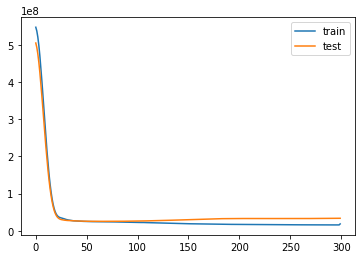

In [17]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

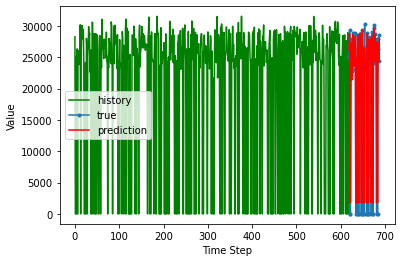

In [18]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

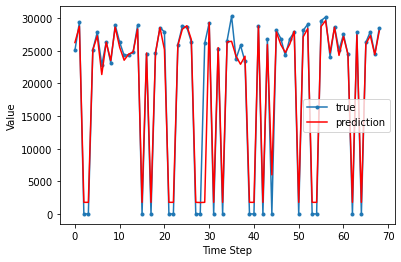

In [19]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [20]:
r2_score(y_test,y_pred)

0.9270290715761069

In [21]:
mean_absolute_percentage_error(y_test,y_pred)

7332.46992076398

In [22]:
mean_squared_error(y_test,y_pred,squared=False)

3256.1249098469902

In [23]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_74659/2328949661.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)


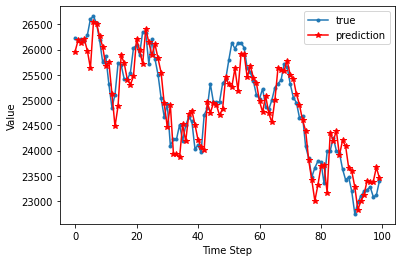

In [24]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [25]:
r2_score(y_val,y_val_pred)

0.8620040665029917

In [26]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.011949991347506676

In [27]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

376.6738973924856